Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step 100/50000 (0.20%), Elapsed time: 0.35s, Reward: 11.6359
Step 200/50000 (0.40%), Elapsed time: 38.87s, Reward: 11.0217
Step 300/50000 (0.60%), Elapsed time: 78.90s, Reward: 11.0699
Step 400/50000 (0.80%), Elapsed time: 118.97s, Reward: 10.9904
Step 500/50000 (1.00%), Elapsed time: 159.00s, Reward: 10.9080
Step 600/50000 (1.20%), Elapsed time: 199.01s, Reward: 10.7874
Step 700/50000 (1.40%), Elapsed time: 239.08s, Reward: 10.8255
Step 800/50000 (1.60%), Elapsed time: 279.12s, Reward: 10.6818
Step 900/50000 (1.80%), Elapsed time: 319.19s, Reward: 10.5716
Step 1000/50000 (2.00%), Elapsed time: 359.26s, Reward: 10.2415
PSNR: 1.66


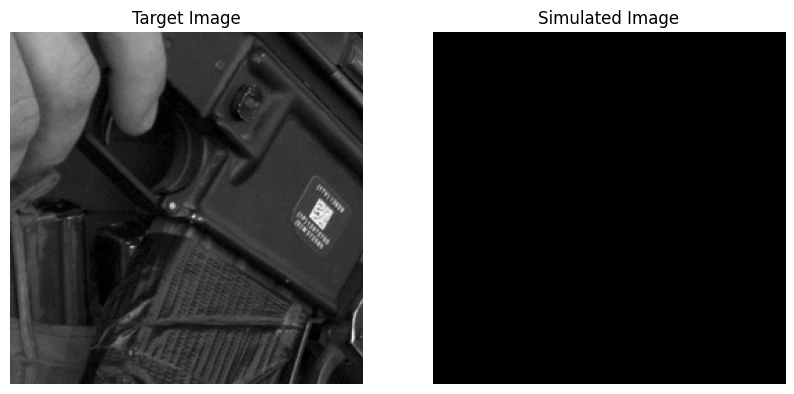

KeyboardInterrupt: 

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torchOptics.optics as tt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import time

warnings.filterwarnings('ignore')

# Define Dataset and Parameters
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'  # Dataset folder
device = 'cuda'  # Define device
z = 2e-3  # Propagation distance
meta = {'dx': [6.3e-6, 6.3e-6], 'wl': [515e-9]}  # Pixel pitch
grid_size = 256  # Resolution of action space
model_save_path = "./sac_cgh_model"  # Path to save the model

# Define Environment
class CGHOpticsEnv(gym.Env):
    def __init__(self, dataset, meta, grid_size, z, device):
        super(CGHOpticsEnv, self).__init__()
        self.dataset = dataset
        self.meta = meta
        self.grid_size = grid_size
        self.z = z
        self.device = device

        self.action_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(grid_size, grid_size), dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(grid_size, grid_size), dtype=np.float32
        )

        self.current_image = None
        self.reset()

    def reset(self, seed=None, **kwargs):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.current_image = self._get_random_image()
        self.field = tt.Tensor(
            torch.ones((1, 1, self.grid_size, self.grid_size), device=self.device), meta=self.meta
        )  # Initial field
        return self.current_image.cpu().numpy(), {}

    def step(self, action):
        # Apply action to the field
        field = tt.Tensor(
            torch.tensor(action, dtype=torch.float32, device=self.device).unsqueeze(0).unsqueeze(0),
            meta=self.meta
        )

        # Simulate output field
        simulated = tt.simulate(field, -self.z).abs() ** 2
        mse_loss = nn.MSELoss()(simulated, self.current_image)
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse_loss)) if mse_loss > 0 else 100.0
        reward = psnr.item()  # Reward based on PSNR

        terminated = psnr > 30  # Terminate if PSNR exceeds 30
        truncated = False
        return simulated.cpu().numpy(), reward, terminated, truncated, {}

    def _get_random_image(self):
        index = np.random.randint(len(self.dataset))
        image = self.dataset[index][0].to(self.device)
        return image

# Define Dataset
dataset = tt.MultiImageDatasetImageio(
    folder,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomCrop((grid_size, grid_size), pad_if_needed=True)
    ])
)

class CustomCallback(BaseCallback):
    def __init__(self, total_timesteps):
        super().__init__()
        self.total_timesteps = total_timesteps
        self.start_time = None

    def _on_training_start(self) -> None:
        self.start_time = time.time()

    def _on_step(self) -> bool:
        # Calculate progress percentage
        progress = self.n_calls / self.total_timesteps * 100

        if self.n_calls % 100 == 0:  # Log progress every 100 steps
            elapsed_time = time.time() - self.start_time
            print(f"Step {self.n_calls}/{self.total_timesteps} "
                  f"({progress:.2f}%), "
                  f"Elapsed time: {elapsed_time:.2f}s, "
                  f"Reward: {self.locals['rewards'][-1]:.4f}")

        if self.n_calls % 1000 == 0:  # Visualize every 1000 steps
            # Current target and simulated images
            env = self.training_env.envs[0]
            target = env.current_image.squeeze().cpu().numpy()
            simulated = env.field.squeeze().cpu().detach().numpy()

            # PSNR calculation
            mse = np.mean((target - simulated) ** 2)
            psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')
            print(f"PSNR: {psnr:.2f}")

            # Visualization
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Target Image")
            plt.imshow(target, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.title("Simulated Image")
            plt.imshow(simulated, cmap="gray")
            plt.axis("off")

            plt.show()
        return True

# Initialize Environment and Model
env = CGHOpticsEnv(dataset, meta, grid_size, z, device)
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Lower learning rate for stability
    buffer_size=50000,
    batch_size=64,
    gradient_steps=64,
    optimize_memory_usage=False,
    train_freq=4,  # Train every 4 steps
)

# Train Model
model.learn(total_timesteps=50000, callback=CustomCallback(total_timesteps=50000))

# Save the Trained Model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# Evaluate Trained Model
obs, _ = env.reset()
for _ in range(10):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated:
        print("Training Complete!")
        break

# Visualize Results
tt.show_with_insets(env.current_image, env.current_image)
tt.show_with_insets(tt.simulate(tt.Tensor(torch.tensor(action).unsqueeze(0).unsqueeze(0).to(device), meta=meta), -z).abs()**2, env.current_image)
